# Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import phik

# evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# pipeline
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

# Problem Statement

Melakukan pembuatan model machine learning yang dapat memprediksi apakah pengguna akan mengklik iklan atau tidak. Untuk meningkatkan strategi pengiklanan, optimalisasi penempatan iklan, dan memahami interaksi dengan iklan online. Model akan dinilai berdasarkan metrics precision untuk mengurangi kasus terprediksi akan klik padahal tidak.

metrics untuk klasifikasi
- akurasi
- f1
- precision *
- recall


- fp -> terprediksi akan klik padahal tidak
- fn -> terprediksi tidak klik padahal klik

# Data Loading
The dataset contains user demographic information, browsing habits, and details related to the display of the advertisement.
This dataset is ideal for building binary classification models to predict user interactions with online ads.

Features

- id: Unique identifier for each user.
- full_name: User's name formatted as "UserX" for anonymity.
- age: Age of the user (ranging from 18 to 64 years).
- gender: The gender of the user (categorized as Male, Female, or Non-Binary).
- device_type: The type of device used by the user when viewing the ad (Mobile, Desktop, Tablet).
- ad_position: The position of the ad on the webpage (Top, Side, Bottom).
- browsing_history: The user's browsing activity prior to seeing the ad (Shopping, News, Entertainment, Education, Social Media).
- time_of_day: The time when the user viewed the ad (Morning, Afternoon, Evening, Night).
- click: The target label indicating whether the user clicked on the ad (1 for a click, 0 for no click).


In [ ]:
df = pd.read_csv('ad_click_dataset.csv')
df

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
...,...,...,...,...,...,...,...,...,...
9995,8510,User8510,NaN,NaN,Mobile,Top,Education,NaN,0
9996,7843,User7843,NaN,Female,Desktop,Bottom,Entertainment,NaN,0
9997,3914,User3914,NaN,Male,Mobile,Side,NaN,Morning,0
9998,7924,User7924,NaN,NaN,Desktop,NaN,Shopping,Morning,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.2+ KB


Terdapat missing value dengan jumlah yang signifikan.

In [ ]:
df.duplicated().sum()

2853

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7147 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7147 non-null   int64  
 1   full_name         7147 non-null   object 
 2   age               3671 non-null   float64
 3   gender            3747 non-null   object 
 4   device_type       5419 non-null   object 
 5   ad_position       5404 non-null   object 
 6   browsing_history  3667 non-null   object 
 7   time_of_day       5435 non-null   object 
 8   click             7147 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 558.4+ KB


# Exploratory Data Analysis

<Axes: xlabel='age', ylabel='Count'>

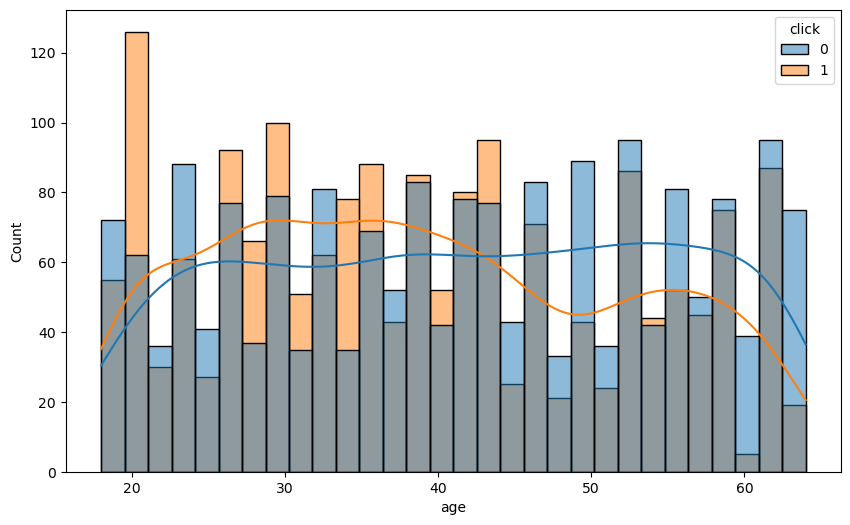

In [ ]:
# age distribution based on wether they click the ads or not
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='click', bins=30, kde=True)

Tidak ada perbedaan yang signifikan untuk usia antara visitor yang klik iklan dengan yang tidak, namun dapat dilihat untuk visitor dengan usia 20 - 40 lebih cenderung untuk klik iklan.

<Axes: xlabel='ad_position', ylabel='count'>

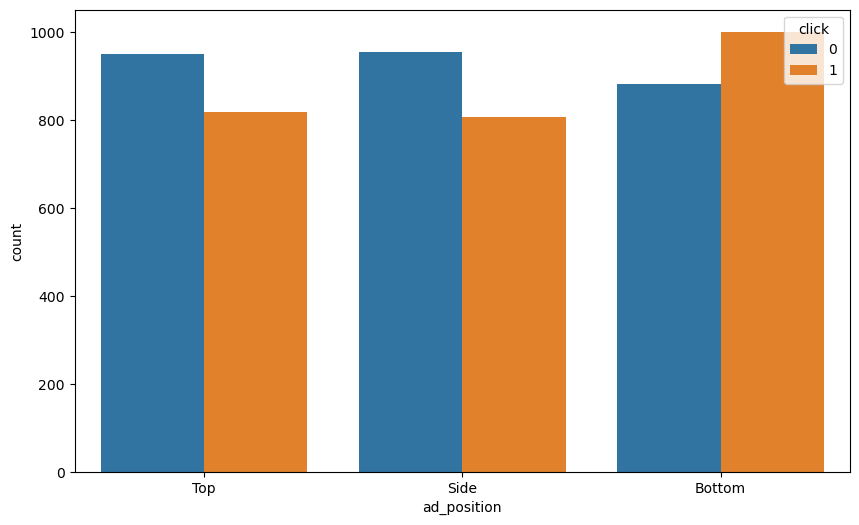

In [ ]:
# barplot of ad position based on wether they click the ads or not
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='ad_position', hue='click')

Tidak ada perbedaan yang begitu signifikan namun dapat dilihat visito cenderung lebih banyak klik iklan di penempatan `bottom`

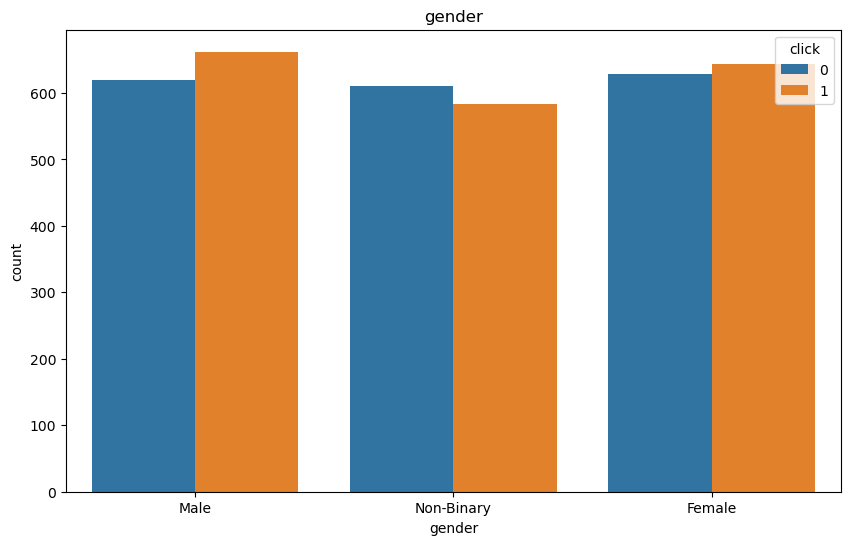

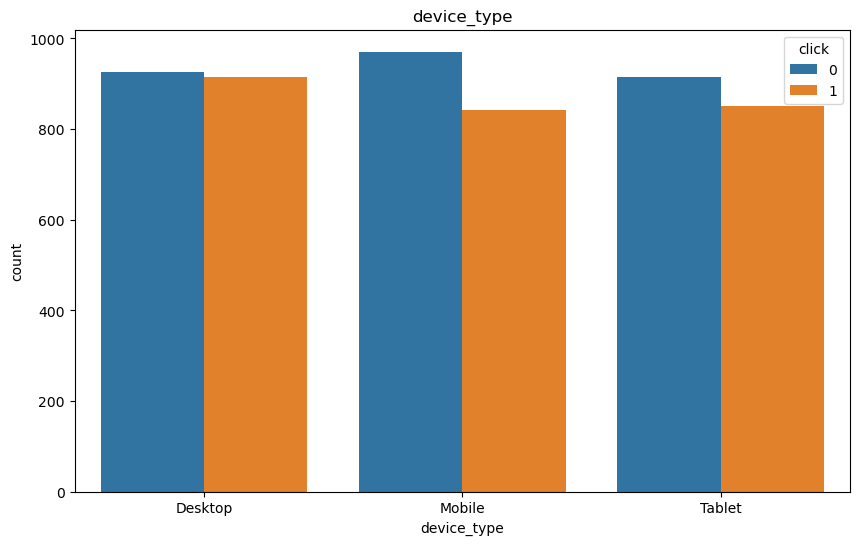

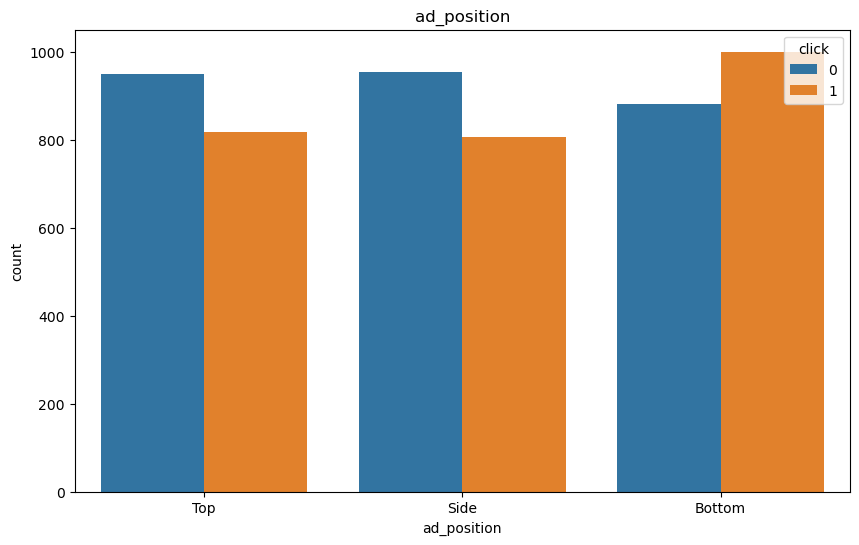

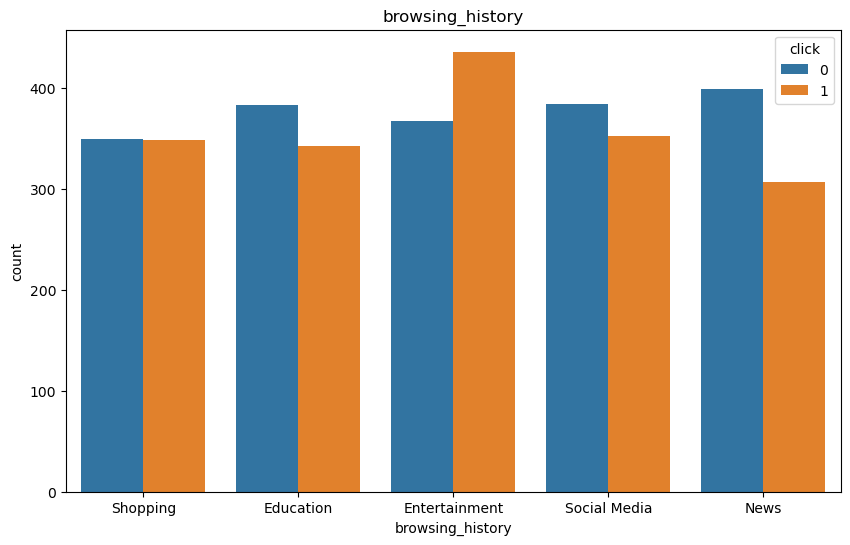

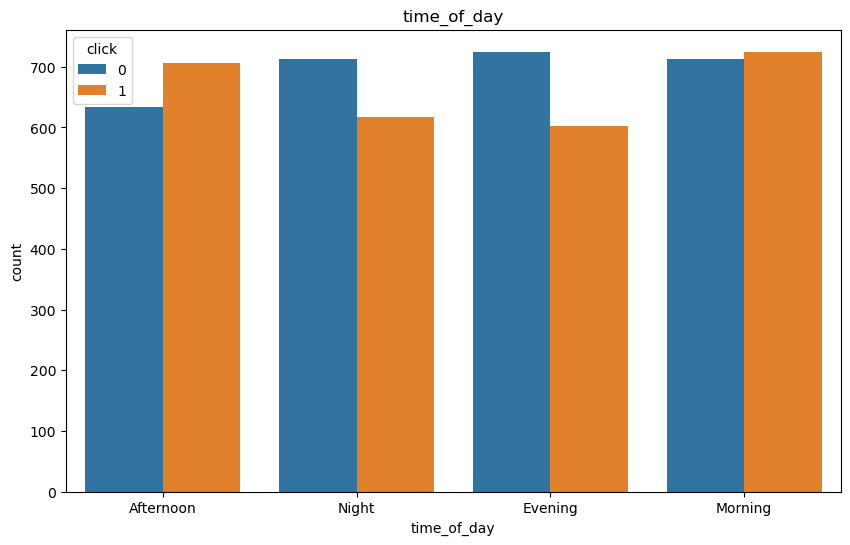

In [ ]:
for i in df.select_dtypes('object').columns:
    if i != 'full_name':
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=i, hue='click')
        plt.title(i)
        plt.show()


In [ ]:
# correlation matrix
phik_overview = df.drop(['id', 'full_name'], axis=1).phik_matrix(interval_cols=['age'])
phik_overview

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
age,1.000000,0.161269,0.082407,0.131456,0.260083,0.092209,0.167283
gender,0.161269,1.000000,0.113159,0.082392,0.072692,0.038745,0.002085
device_type,0.082407,0.113159,1.000000,0.084955,0.095959,0.033903,0.011050
ad_position,0.131456,0.082392,0.084955,1.000000,0.078897,0.000000,0.039303
browsing_history,0.260083,0.072692,0.095959,0.078897,1.000000,0.038073,0.052428
time_of_day,0.092209,0.038745,0.033903,0.000000,0.038073,1.000000,0.081994
click,0.167283,0.002085,0.011050,0.039303,0.052428,0.081994,1.000000


Dari semua fitur tidak ada yang memiliki korelasi signifikan terhadap click. Yang memiliki efek terbesar adalah age dengan nilai korelasi `0.16`

# Feature Engineering

In [ ]:
# Pilih yang mana fitur dan yang mana target
X = df.drop(['id', 'full_name', 'click'], axis=1)
y = df['click']

In [ ]:
# split train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify= y,
                                                    random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5717, 6)
(1430, 6)
(5717,)
(1430,)


In [ ]:
y_train.value_counts(normalize=True)

click
1    0.510233
0    0.489767
Name: proportion, dtype: float64

target class balanced

## Missing Values

In [ ]:
X_train.head(10)

,age,gender,device_type,ad_position,browsing_history,time_of_day
4377,42.0,NaN,Desktop,Side,Shopping,Night
6478,53.0,Male,Tablet,Bottom,Education,Night
3376,NaN,Female,Desktop,Bottom,Shopping,NaN
4570,32.0,NaN,Mobile,Top,Education,NaN
3811,NaN,Non-Binary,Desktop,Bottom,NaN,NaN
7636,25.0,Female,Desktop,Top,NaN,Morning
8183,NaN,NaN,Desktop,Top,NaN,NaN
2375,NaN,Female,Desktop,Side,Education,NaN
1993,NaN,Female,NaN,Top,Entertainment,NaN
1745,NaN,Male,Desktop,Side,NaN,NaN


In [ ]:
X_train.isna().sum()

age                 2748
gender              2732
device_type         1381
ad_position         1396
browsing_history    2759
time_of_day         1372
dtype: int64

Karena Missing terdapat sangat banyak missing values, kita tidak akan drop melainkan akan diisi dengan menggunakan `KNNImputer`

In [ ]:
imputer_knn = KNNImputer(n_neighbors=5)
imputer_simple = SimpleImputer(strategy='most_frequent')
impute_constant = SimpleImputer(strategy='constant', fill_value='unknown')

## Scaling

In [ ]:
scaler = StandardScaler()

## Encoding

In [ ]:
nominal = ['gender', 'device_type', 'ad_position', 'browsing_history']
ordinal = ['time_of_day']

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

oe = OrdinalEncoder(categories=[['Morning', 'Afternoon', 'Evening', 'Night']])

## Preprocess Pipeline

In [ ]:
num_pipe = make_pipeline(imputer_knn, scaler)
nom_pipe = make_pipeline(impute_constant, ohe)
ord_pipe = make_pipeline(imputer_simple, oe)

preprocess = ColumnTransformer([('numerical', num_pipe, ['age']),
                                ('nominal', nom_pipe, nominal),
                                ('ordinal', ord_pipe, ordinal)],
                                remainder='drop')

preprocess

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['age']),
                                ('nominal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['gender', 'device_type', 'ad_position',
                                  'browsing_history']),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Morning',
                                                                              'Afternoon',
                                                                              'Evening',
                                                                              'Night']]))]),
                                 ['time_of_day'])])

In [ ]:
a = preprocess.fit_transform(X_train)
pd.DataFrame(a, columns = preprocess.get_feature_names_out())

,numerical__age,nominal__gender_Female,nominal__gender_Male,nominal__gender_Non-Binary,nominal__gender_unknown,nominal__device_type_Desktop,nominal__device_type_Mobile,nominal__device_type_Tablet,nominal__device_type_unknown,nominal__ad_position_Bottom,nominal__ad_position_Side,nominal__ad_position_Top,nominal__ad_position_unknown,nominal__browsing_history_Education,nominal__browsing_history_Entertainment,nominal__browsing_history_News,nominal__browsing_history_Shopping,nominal__browsing_history_Social Media,nominal__browsing_history_unknown,ordinal__time_of_day
0,1.596513e-01,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
1,1.314736e+00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
2,-7.461244e-16,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-8.904254e-01,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-7.461244e-16,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5712,-7.461244e-16,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5713,-7.461244e-16,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5714,-7.461244e-16,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5715,-4.703947e-01,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Modeling

model yang akan dicoba:
- knn
- logistic regression
- random forest
- adaboost

## Model Definition

In [ ]:
knn = KNeighborsClassifier()
logreg = LogisticRegression()
rf_cls = RandomForestClassifier()
ada_cls = AdaBoostClassifier()

In [ ]:
# model pipeline
pipe_knn = Pipeline([('prep', preprocess), ('knn', knn)])
pipe_logreg = Pipeline([('prep', preprocess), ('logreg', logreg)])
pipe_rf = Pipeline([('prep', preprocess), ('rf', rf_cls)])
pipe_ada = Pipeline([('prep', preprocess), ('ada', ada_cls)])


Model akan dipilih untuk dilakukan hyperparameter tuning dengan membandingkan hasil cross validation tiap model.

## Cross Validation

In [ ]:
# cross validation

cv_knn = cross_val_score(pipe_knn, X_train, y_train, cv=5, scoring='precision')
cv_logreg = cross_val_score(pipe_logreg, X_train, y_train, cv=5, scoring='precision')
cv_rf = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='precision')
cv_ada = cross_val_score(pipe_ada, X_train, y_train, cv=5, scoring='precision')

In [ ]:
model = ['KNN', 'Logistic Regression', 'Random Forest', 'AdaBoost']
cv_mean = [cv_knn.mean(), cv_logreg.mean(), cv_rf.mean(), cv_ada.mean()]
cv_std = [cv_knn.std(), cv_logreg.std(), cv_rf.std(), cv_ada.std()]

result = pd.DataFrame({'model': model, 'cv_mean': cv_mean, 'cv_std': cv_std})
result

,model,cv_mean,cv_std
0,KNN,0.563511,0.004063
1,Logistic Regression,0.581897,0.009467
2,Random Forest,0.564521,0.004578
3,AdaBoost,0.588788,0.012130


Berdasarkan hasil cross validation didapatkan bahwa adaboost dengan default hyperparameter menghasilkan score paling baik diantara yang lain. Adaboost akan dilanjutkan untuk hyperparameter tuning

## Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning

ada_param_grid = {'ada__n_estimators': [50, 100, 200],
                  'ada__learning_rate': [0.1, 0.5, 1]
                  }

In [ ]:
# gridsearch
ada_grid = GridSearchCV(pipe_ada,
                        param_grid=ada_param_grid,
                        cv=5,
                        scoring='precision',
                        n_jobs=-1,
                        verbose=1)

ada_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['age']),
                                                                        ('nominal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='unknown',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse...
                                                                          'browsing_history']),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder(categories=[['Morning',
                                                                                                                      'Afternoon',
                                                                                                                      'Evening',
                                                                                                                      'Night']]))]),
                                                                         ['time_of_day'])])),
                                       ('ada', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'ada__learning_rate': [0.1, 0.5, 1],
                         'ada__n_estimators': [50, 100, 200]},
             scoring='precision', verbose=1)

In [ ]:
pd.DataFrame(ada_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ada__learning_rate,param_ada__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.532246,0.102434,0.247145,0.039917,0.1,50,"{'ada__learning_rate': 0.1, 'ada__n_estimators...",0.562743,0.572917,0.598621,0.570093,0.571221,0.575119,0.012254,9
1,2.070443,0.317177,0.218399,0.043072,0.1,100,"{'ada__learning_rate': 0.1, 'ada__n_estimators...",0.571010,0.571429,0.606607,0.581159,0.574303,0.580902,0.013356,8
2,2.455407,0.067093,0.197687,0.052553,0.1,200,"{'ada__learning_rate': 0.1, 'ada__n_estimators...",0.572508,0.577419,0.606383,0.586790,0.577953,0.584210,0.012004,7
3,1.167139,0.353913,0.246204,0.098070,0.5,50,"{'ada__learning_rate': 0.5, 'ada__n_estimators...",0.574695,0.586601,0.604615,0.595469,0.580952,0.588467,0.010577,5
4,1.758992,0.121642,0.223794,0.030090,0.5,100,"{'ada__learning_rate': 0.5, 'ada__n_estimators...",0.574242,0.586583,0.597809,0.595122,0.584375,0.587626,0.008374,6
5,2.082408,0.204066,0.255505,0.039368,0.5,200,"{'ada__learning_rate': 0.5, 'ada__n_estimators...",0.568862,0.589425,0.599057,0.602236,0.586047,0.589125,0.011753,3
6,0.890909,0.087810,0.170217,0.020381,1,50,"{'ada__learning_rate': 1, 'ada__n_estimators':...",0.567608,0.600000,0.592949,0.599665,0.583717,0.588788,0.012130,4
7,1.345340,0.049091,0.217075,0.031674,1,100,"{'ada__learning_rate': 1, 'ada__n_estimators':...",0.567809,0.600316,0.592248,0.598361,0.589704,0.589688,0.011605,2
8,1.355793,0.213389,0.080142,0.014914,1,200,"{'ada__learning_rate': 1, 'ada__n_estimators':...",0.569322,0.603421,0.597484,0.591415,0.592248,0.590778,0.011557,1


In [ ]:
ada_grid.best_params_

{'ada__learning_rate': 1, 'ada__n_estimators': 200}

In [ ]:
ada_grid.best_score_

0.5907780557843689

In [ ]:
best_model = ada_grid.best_estimator_
best_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('nominal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'device_type',
                                                   'ad_position',
                                                   'browsing_history']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Morning',
                                                                                               'Afternoon',
                                                                                               'Evening',
                                                                                               'Night']]))]),
                                                  ['time_of_day'])])),
                ('ada', AdaBoostClassifier(learning_rate=1, n_estimators=200))])

Setelah dilakukan hyperparameter tuning didapat adaboost dengan parameter terbaik tertera diatas

# Model Evaluation

In [ ]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# classification report
print('Train Result')
print('precision:', precision_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print('-----------------------------------')
print('Test Result')
print('precision:', precision_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print('-----------------------------------')

Train Result
precision: 0.6036341238065907
              precision    recall  f1-score   support

           0       0.61      0.54      0.57      2800
           1       0.60      0.67      0.64      2917

    accuracy                           0.61      5717
   macro avg       0.61      0.61      0.61      5717
weighted avg       0.61      0.61      0.61      5717

-----------------------------------
Test Result
precision: 0.5861650485436893
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       700
           1       0.59      0.66      0.62       730

    accuracy                           0.59      1430
   macro avg       0.59      0.59      0.59      1430
weighted avg       0.59      0.59      0.59      1430

-----------------------------------


Train Result


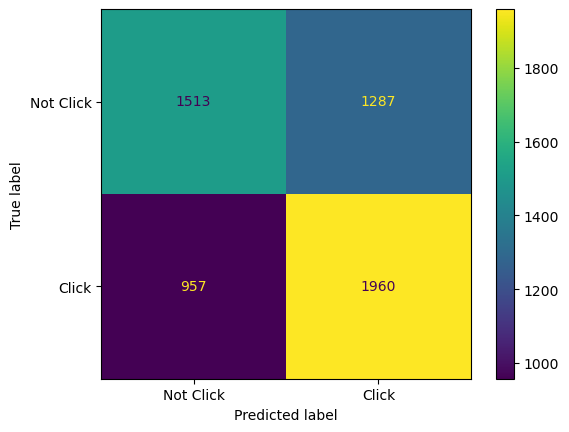

-----------------------------------
Test Result


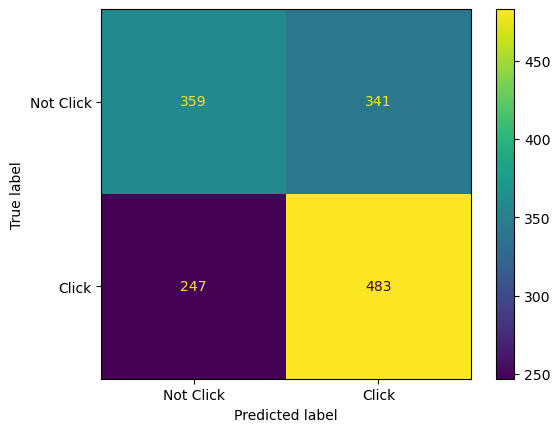

In [ ]:
# confusion matrix
print('Train Result')
train_mtx = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(train_mtx, display_labels=['Not Click', 'Click']).plot()
plt.show()
print('-----------------------------------')
print('Test Result')
test_mtx = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(test_mtx, display_labels=['Not Click', 'Click']).plot()
plt.show()

Model tergolong underfit karena algoritma tidak dapat membaca pattern dalam data. Hal ini dapat disebabkan karena banyak missing value pada data dan juga kemungkinan fitur yang ada tidak memiliki korelasi dengan target

# Kesimpulan

Beberapa yang dapat disimpulkan dari keseluruhan proses